# Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### From sklearn - Preprocesing 

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# Dimension reduction 
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

# Clustering 
from sklearn.manifold import TSNE

# K-fold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

# From sklearn - Model creation

from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import multilabel_confusion_matrix

from sklearn import metrics 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

-----
# Reading files and merging features with labels

In [4]:
#dataset = pd.read_csv("Genes\data.csv")
dataset = pd.read_csv('/Users/pedrorodriguezdeledesmajimenez/1_Coding/Datasets/RUG_Pattern-recognition_Assignment-2/Task 1/Genres/data.csv')

#labels = pd.read_csv("Genes\labels.csv")
dataset_labels =pd.read_csv('/Users/pedrorodriguezdeledesmajimenez/1_Coding/Datasets/RUG_Pattern-recognition_Assignment-2/Task 1/Genres/labels.csv')

In [5]:
# Merging both datasets and removing first column

dataset = pd.merge(dataset, dataset_labels, on='Unnamed: 0').drop("Unnamed: 0", axis=1)

In [6]:
print(f'Dataset consists of {dataset.shape[0]} input sample vectors, each vector has {dataset.shape[1]} '\
      f'gene features.\nAlso the availbale classes are {len(dataset["Class"].unique())}.'\
      f' The possible choises are {", ".join(val for val in dataset.Class.unique())}.')
class_counts = dataset.Class.value_counts()
print(f'As we can see, we have class imbalance.\n\n{class_counts.to_string()}')

Dataset consists of 801 input sample vectors, each vector has 20532 gene features.
Also the availbale classes are 5. The possible choises are PRAD, LUAD, BRCA, KIRC, COAD.
As we can see, we have class imbalance.

BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78


----
# Preprocesing data

###  1. Encoding labels

In [7]:
# Encode the labels and updaate values

le = preprocessing.LabelEncoder()
dataset["Class"] = le.fit_transform(dataset_labels.drop("Unnamed: 0", axis=1).values.ravel())

In [8]:
# Let´s store all the labels
keys = le.classes_

# And now store labels with their encoded value 
values = le.transform(le.classes_)
dictionary = dict(zip(keys, values))
dictionary

{'BRCA': 0, 'COAD': 1, 'KIRC': 2, 'LUAD': 3, 'PRAD': 4}

In [9]:
dataset.Class.value_counts()

0    300
2    146
3    141
4    136
1     78
Name: Class, dtype: int64

### 2 Normalization: min_max_scaler



In [10]:
# Lets store the dataset values without the columns titles
x = dataset.iloc[:, :-1].values 

# Let´s create an instance with the normalice function
min_max_scaler = preprocessing.MinMaxScaler()

# Let´s fit the normilice function
x_scaled = min_max_scaler.fit_transform(x)

# Let´s put in the dataframe the values scaled
dataset.iloc[:, :-1] = pd.DataFrame(x_scaled)

In [54]:
stats=pd.DataFrame()
stats["mean"]=dataset.mean()
stats["Std.Dev"]=dataset.std()
stats["Var"]=dataset.var()
stats_2 =stats.sort_values(by=['Var','mean'],ascending=False)
stats_2.head()

,mean,Std.Dev,Var
Class,1.659062,1.536893,2.362040
gene_17496,0.000538,1.008205,1.016478
gene_11130,0.000538,1.008205,1.016478
gene_16580,0.000538,1.008205,1.016478
gene_14160,0.000538,1.008205,1.016478


### Search for outliers in dataset

In [16]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor()
# fit_predict return a numpy array of 1 if not an outlier and -1 if an outlier
outliers = lof.fit_predict(dataset.iloc[:,:-1])

# select all rows that are not outliers
mask = outliers != -1
dataset.shape

#unpack the mask to keep only non-outlier examples
dataset = dataset[[*mask]]

print(f'Data size after removing outliers is: {dataset.shape}.')

Data size after removing outliers is: (789, 20532).


#### Input for the reduction algorithms

In [17]:
dataset.shape

(789, 20532)

-----------
## Dimensionality reduction:  1.Principal Component Analysis

Here we make an analysis of the method 


In [18]:
# Create PCA object to keep 95% of variance

pca = PCA(0.70)

# Apply PCA in input vector
pca.fit(dataset.iloc[:,:-1]) 

# Save results in an np.array
reduced = pca.transform(dataset.iloc[:,:-1])

# Save labels in an np.array
x = dataset['Class'].to_numpy()

# Create final dataframe with reduced dimensions
dataset_reduced_PCA = pd.DataFrame(np.column_stack((reduced, x)))

Number of features in the original dataset: 20532 <br>
After applying PCA to the dataset, we end up with:

In [19]:
dataset_reduced_PCA.shape[1]

85

In [20]:
# We are going to rename the columns name with the PCA components name

for count, column_name in enumerate(dataset_reduced_PCA.columns):
    
    if count < len(dataset_reduced_PCA.columns)-1:
        
        dataset_reduced_PCA.rename(columns={column_name : f"PCA{count+1}"}, inplace=True)
    else:
        dataset_reduced_PCA.rename(columns={column_name : "Label"}, inplace=True)

#### Lets display the explained variance of each PCA component

In [22]:
pca.explained_variance_ratio_.shape

(84,)

In [23]:
# To see the percentage of variation thaat each principal components accounts for

per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
per_var.shape

(84,)

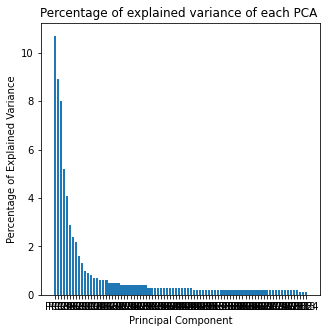

In [24]:
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
plt.figure(figsize=(5,5))
plt.bar(x=range(1,len(per_var)+1),height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Percentage of explained variance of each PCA ')
plt.show()

In [25]:
# Here we calculate the cumulative sum of the variance so we can plot and see how the variance of the PCA evolute 
cum_sum_eigenvalues = np.cumsum(pca.explained_variance_ratio_)
length = cum_sum_eigenvalues.shape[0]

# Let´s see the cummulative variance
cum_sum_eigenvalues[length-1]

(84,)

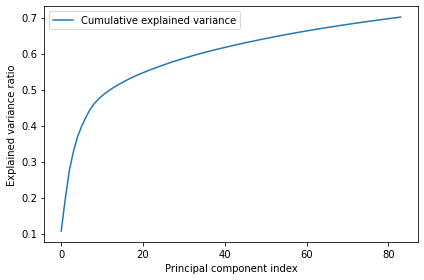

In [28]:
# Plot with regards of components

#plt.bar(range(0,len(exp_var_pca[:150])), exp_var_pca[:150], alpha=0.5, align='center', label='Individual explained variance')
#plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.plot(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues,label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("Explained_variance_VS_Cumulative_sum.png")
plt.show()

In [29]:
#Final dataset after feature extraction and further process

dataset_reduced_PCA.shape

(789, 85)

-----------
## Dimensionality reduction:  2.Linear Discriminant Analysis

Here we make an analysis of the method 

Linear Discriminant Analysis, or LDA, is a multi-class classification algorithm that can be used for dimensionality reduction.

Is like PCA, but it focuses on maximizing the seperatibility among categories

The number of dimensions for the projection is limited to 1 and C-1, where C is the number of classes.

In [40]:
# define transform
lda = LinearDiscriminantAnalysis(n_components=2)
# prepare transform on dataset
lda.fit(dataset.iloc[:,:-1].values, dataset.iloc[:,-1:].values.ravel())
# apply transform to dataset
reduced_lda = lda.transform(dataset.iloc[:,:-1].values)
reduced_lda.shape

(789, 2)

In [41]:
# Save labels in an np.array
y_lda = dataset['Class'].to_numpy()
# apply transform to dataset
reduced_lda = lda.transform(dataset.iloc[:,:-1].values)
reduced_lda.shape

(789, 2)

In [42]:
# Create final dataframe with reduced dimensions
dataset_reduced_LDA = pd.DataFrame(np.column_stack((reduced_lda, y_lda)))

#### Lets display the explained variance of each PCA component

In [43]:
lda.explained_variance_ratio_.shape

(2,)

In [44]:
# To see the percentage of variation thaat each principal components accounts for

per_var = np.round(lda.explained_variance_ratio_*100, decimals=1)
per_var.shape

(2,)

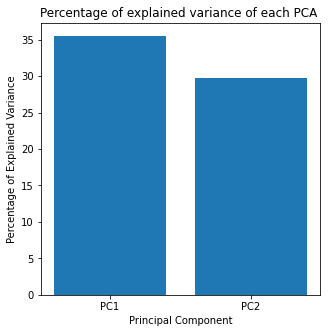

In [45]:
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
plt.figure(figsize=(5,5))
plt.bar(x=range(1,len(per_var)+1),height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Percentage of explained variance of each PCA ')
plt.show()

In [46]:
# Here we calculate the cumulative sum of the variance so we can plot and see how the variance of the PCA evolute 

sum_lda = np.cumsum(lda.explained_variance_ratio_)
length = sum_lda.shape[0]

# Let´s see the cummulative variance
sum_lda[length-1]

(2,)

In [49]:
# Here we calculate the cumulative sum of the variance so we can plot and see how the variance of the PCA evolute 

cum_sum_lda = np.cumsum(lda.explained_variance_ratio_)
length = cum_sum_lda.shape[0]

# Let´s see the cummulative variance
cum_sum_lda[length-1]

0.6534905522486745

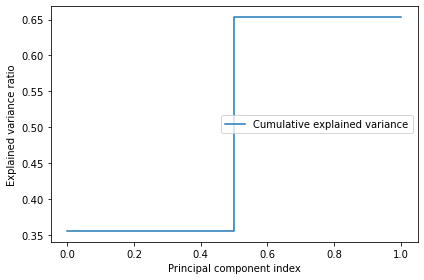

In [50]:
# Plot with regards of components

#plt.bar(range(0,len(exp_var_pca[:150])), exp_var_pca[:150], alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_lda)), cum_sum_lda, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Output of preprocesing 

In [51]:
dataset_reduced_PCA.shape

(789, 85)

In [52]:
dataset_reduced_ISO.shape # We are not going to use for the model this method

(789, 101)

In [53]:
dataset_reduced_LDA.shape

(789, 3)